---
title: "Efficiency of Univariate Kernel Density Estimation with TensorFlow"
subtitle: "Bachelor Thesis"
author: ["Marc Steiner"]
supervisor: ["Jonas Eschle"]
institute: ["University of Zurich"]
keywords: [Kernel Density Estimation, Python, TensorFlow]
lang: "en"
reference-section-title: "References"
titlepage: True
titlepage-background: "templates/images/background.pdf"
titlepage-text-color: "FFFFFF"
toc: True
toc-own-page: True
lof: True
lot: True
lol: True
thanks: True
listings-no-page-break: False
footnotes-pretty: True
logo: "templates/images/uzh-logo.png"
titlegraphic: "templates/images/uzh-logo.png"
highlight-style: "darkbreeze"
linkReferences: True
listings: True
autoEqnLabels: True
tableEqns: True

...
# Abstract {.unnumbered.unlisted}

This study aims at comparing the speed and accuracy of differentu methods for one-dimensional kernel density estimation in Python/TensorFlow, especially concerning applications in high energy physics.
Starting from the basic algorithm, several optimizations from recent papers are introduced and combined to ameliorate the effeciency of the algorithm.

# Introduction

## Kernel Density Estimation

Kernel Density Estimation[@rosenblatt1956] has improved, see figure [@fig:kde].

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from zfit_benchmark.timer import Timer
import zfit as z


# Methods

## Generation of Test Distribution

Listing: Test Distribution generation

In [16]:
r_seed = 1978239485
n_datapoints = 1000000

tfd = tfp.distributions
mix_3gauss_1exp_1uni = tfd.Mixture(
  cat=tfd.Categorical(probs=[0.1, 0.2, 0.1, 0.4, 0.2]),
  components=[
    tfd.Normal(loc=-1., scale=0.4),
    tfd.Normal(loc=+1., scale=0.5),
    tfd.Normal(loc=+1., scale=0.3),
    tfd.Exponential(rate=2),
    tfd.Uniform(low=-5, high=5)
])

data = mix_3gauss_1exp_1uni.sample(sample_shape=n_datapoints, seed=r_seed).numpy()

1.305446316022425889968872070
4.087360636971425265073776245
5.025625200010836124420166016


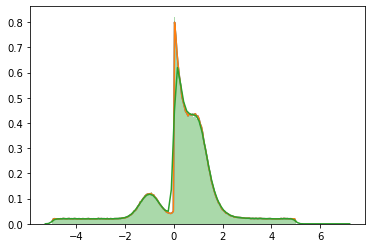

In [17]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

ax = plt.gca()

n_testpoints = 200
fac1 = 1.0 / np.sqrt(2.0 * np.pi)
exp_fac1 = -1.0/2.0
h1 = 0.01
y_fac1 = 1.0/(h1*n_datapoints)


with Timer ("Benchmarking") as timer:
    with timer.child('tf.simple-kde'):
        @tf.function(autograph=False)
        def tf_kde():

            fac = tf.constant(fac1, tf.float64)
            exp_fac = tf.constant(exp_fac1, tf.float64)
            y_fac = tf.constant(y_fac1, tf.float64)
            h = tf.constant(h1, tf.float64)
            data_tf = tf.convert_to_tensor(data, tf.float64)


            gauss_kernel = lambda x: tf.math.multiply(fac, tf.math.exp(tf.math.multiply(exp_fac, tf.math.square(x))))
            calc_value = lambda x: tf.math.multiply(y_fac, tf.math.reduce_sum(gauss_kernel(tf.math.divide(tf.math.subtract(x, data_tf), h))))

            x = tf.linspace(tf.cast(-5.0, tf.float64), tf.cast(5.0, tf.float64), num=tf.cast(n_testpoints, tf.int64))
            y = tf.zeros(n_testpoints)
        

            return x, tf.map_fn(calc_value, x)

        x, y = tf_kde()
        sns.lineplot(x, y, ax=ax)
        timer.stop()

    with timer.child('simple-kde'):

        fac = fac1
        exp_fac = exp_fac1

        y_fac = y_fac1
        h = h1
        
        gauss_kernel = lambda x: fac * np.exp(exp_fac * x**2)

        x2 = np.linspace(-5.0, 5.0, num=n_testpoints)     
        y2 = np.zeros(n_testpoints)

        for i, x_i in enumerate(x2):
            y2[i] = y_fac * np.sum(gauss_kernel((x_i-data)/h))
        sns.lineplot(x2,y2, ax=ax)
        timer.stop()

    with timer.child('sns.distplot'):
        plot = sns.distplot(data, bins=1000, kde=True, rug=False, ax=ax)
        timer.stop()

print(timer.child('tf.simple-kde').elapsed)
print(timer.child('simple-kde').elapsed)
print(timer.child('sns.distplot').elapsed)

plt.savefig('plots/kde.png')

![Kernel Density Estimation](plots/kde.png){#fig:kde}

$$
\mathbf{r} \equiv \begin{bmatrix}
y \\
\theta
\end{bmatrix}
$$ {#eq:eq1}

<!--

In [35]:
# Convert notebook to PDF
!./scripts/paperize.sh

Tools already installed. :-)
[NbConvertApp] Converting notebook /home/jovyan/work/scripts/../thesis.ipynb to markdown
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('truncated' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][9]['outputs'][0]:
{'name': 'stdout',
 'output_type': 'stream',
 'text': 'Tools already installed. :-)\n'
         '[NbConvertApp] Converting notebook ...',
 'truncated': False}
[NbConvertApp] Support files will be in thesis_files/
[NbConvertApp] Making directory /home/jovyan/work/scripts/../thesis_files
[NbConvertApp] Making directory /home/jovyan/work/scripts/../thesis_files
[NbConvertApp] Writing 4248 bytes to /home/jovyan/work/scripts/../thesis.md


-->